In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('https://github.com/aflaxman/learning-about-transformers-for-epidemic-forecasting/raw/refs/heads/main/week-02/data/wa_measles.csv')
df

,epi_week,state,loc,loc_type,disease,cases,incidence_per_100000
0,192801,WA,WASHINGTON,STATE,MEASLES,230,14.83
1,192802,WA,WASHINGTON,STATE,MEASLES,269,17.34
2,192803,WA,WASHINGTON,STATE,MEASLES,243,15.67
3,192804,WA,WASHINGTON,STATE,MEASLES,198,12.77
4,192805,WA,WASHINGTON,STATE,MEASLES,292,18.83
...,...,...,...,...,...,...,...
3247,200148,WA,WASHINGTON,STATE,MEASLES,0,0.00
3248,200149,WA,WASHINGTON,STATE,MEASLES,0,0.00
3249,200150,WA,WASHINGTON,STATE,MEASLES,0,0.00
3250,200151,WA,WASHINGTON,STATE,MEASLES,0,0.00


# Use statsmodels ARIMA to fit and predict real data from Project Tycho

In [3]:
y = df['incidence_per_100000'].values

# turn df['epi_week'] into an array of dates
dates = pd.to_datetime(df['epi_week'].astype(str) + '-1', format='%Y%W-%w')

series = np.log(1+pd.Series(y, index=dates, name="wa_measles_cases"))
# display(series)

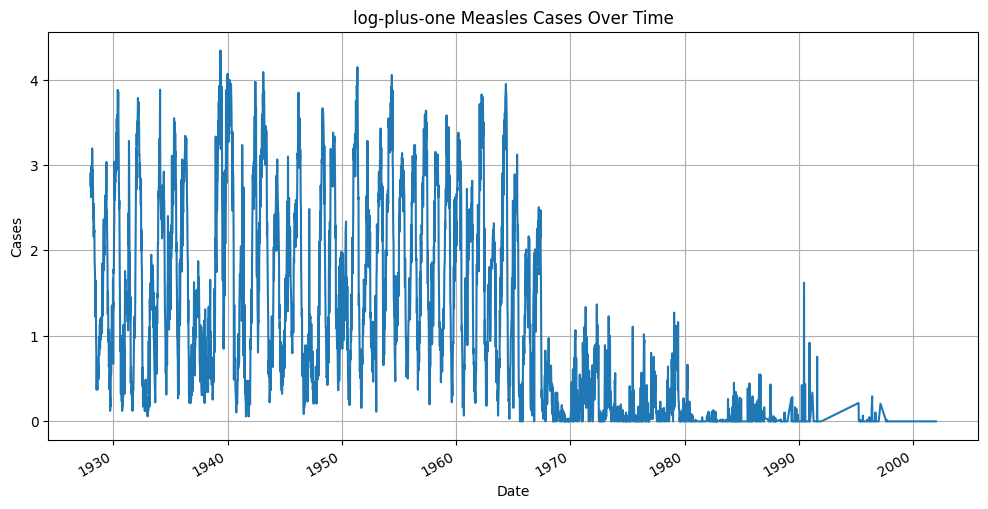

In [4]:
series.plot(figsize=(12, 6))
plt.title('log-plus-one Measles Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.grid(True)

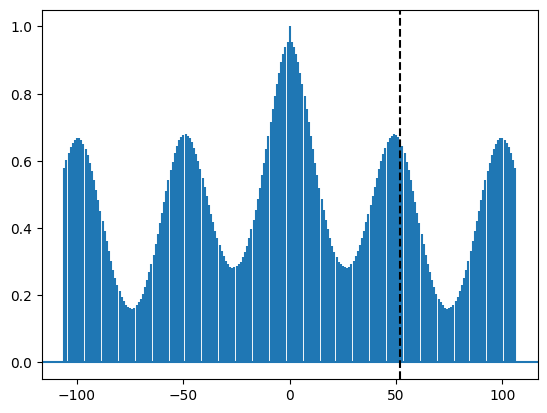

In [5]:
plt.acorr(series-np.mean(series), maxlags=106)
plt.axvline(52, color='k', linestyle='--');

In [6]:
# -------------------------------------------------------------
# 2. Split into train / test
# -------------------------------------------------------------

# FIXME: ARIMA assumes data is uniformly spaces with no missing values
# so fix the series or use the SARIMAX model instead

n_train = 420-52
n_test = 52*4
train, test = series[:n_train].values, series[n_train:(n_train+n_test)].values

# -------------------------------------------------------------
# 3. Fit ARIMA on the training portion
# -------------------------------------------------------------
model = ARIMA(train, order=(2, 0, 1), seasonal_order=(1, 0, 1, 52))
results = model.fit()

# -------------------------------------------------------------
# 4. Forecast over the test period
# -------------------------------------------------------------
forecast_res = results.get_forecast(steps=n_test)
pred_mean = forecast_res.predicted_mean
ci = forecast_res.conf_int()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:
# -------------------------------------------------------------
# 5. Compute a simple accuracy metric (RMSE)
# -------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f"Validation RMSE: {rmse:0.2f}")

Validation RMSE: 0.87


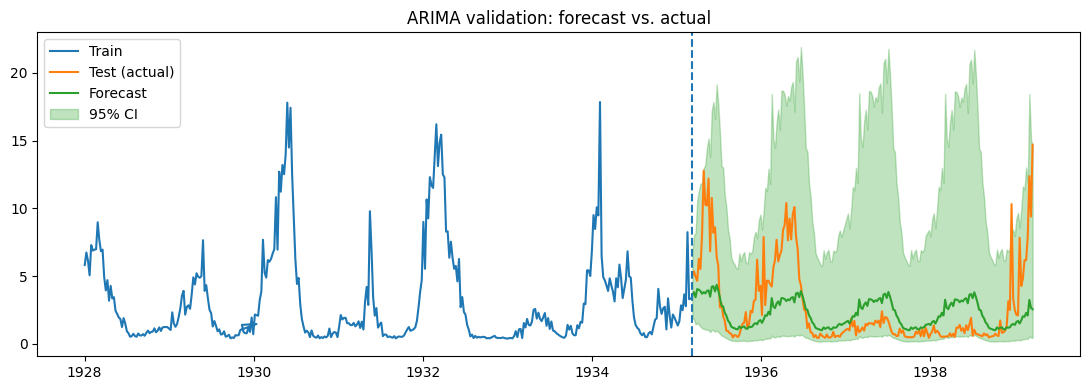

In [8]:
# -------------------------------------------------------------
# 6. Plot: train, validation, forecast, and 95 % CI
# -------------------------------------------------------------
plt.figure(figsize=(11, 4))
plt.plot(series.index[:n_train], np.exp(train-1), label="Train")
plt.plot(series.index[n_train:(n_train+n_test)], np.exp(test-1), label="Test (actual)")
plt.plot(series.index[n_train:(n_train+n_test)], np.exp(pred_mean-1), label="Forecast", color='C2')
plt.fill_between(series.index[n_train:(n_train+n_test)],
                 np.exp(ci[:, 0]-1),
                 np.exp(ci[:, 1]-1),
                 alpha=0.3, label="95% CI", color='C2')
plt.axvline(series.index[n_train], linestyle="--")  # marks forecast origin
plt.title("ARIMA validation: forecast vs. actual")
plt.legend()
plt.tight_layout()

# Which parameters seem best, based on the data?

In [9]:
import itertools
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

p = [0,1,2,3,5]
q = [0,1]
d = [0]
pdq     = list(itertools.product(p, d, q))
#season  = [(x[0], x[1], x[2], 52) for x in pdq if np.all(np.array(x) < 2)]  # weekly seasonality
season = [(1,0,1,52)]

best_rmse   = np.inf
best_order = None
best_seasonal = None
best_model = None

for order in pdq:
    for s_order in season:
        try:
            print(f"Testing ARIMA{order}x{s_order}...")
            mod = ARIMA(y, order=order, seasonal_order=s_order)
            res = mod.fit()
            print(f"  AIC: {res.aic:.2f}")
            forecast_res = res.get_forecast(steps=n_test)
            pred_mean = forecast_res.predicted_mean
            ci = forecast_res.conf_int()
            rmse = np.sqrt(mean_squared_error(test, pred_mean))
            print(f"  Validation RMSE: {rmse:0.2f}")
            if rmse < best_rmse:
                best_rmse, best_order, best_seasonal, best_res = \
                    rmse, order, s_order, res
                print(f"  New best model! RMSE: {best_rmse:.2f}")
        except Exception:
            print(f"  Failed to fit ARIMA{order}x{s_order}.")
            continue                                   # skip non-invertible combos
        print()

Testing ARIMA(0, 0, 0)x(1, 0, 1, 52)...
  AIC: 23175.29
  Validation RMSE: 1.76
  New best model! RMSE: 1.76

Testing ARIMA(0, 0, 1)x(1, 0, 1, 52)...
  AIC: 21286.74
  Validation RMSE: 2.08

Testing ARIMA(1, 0, 0)x(1, 0, 1, 52)...
  AIC: 18566.44
  Validation RMSE: 3.88

Testing ARIMA(1, 0, 1)x(1, 0, 1, 52)...
  AIC: 18083.97
  Validation RMSE: 3.58

Testing ARIMA(2, 0, 0)x(1, 0, 1, 52)...
  AIC: 17985.01
  Validation RMSE: 3.66

Testing ARIMA(2, 0, 1)x(1, 0, 1, 52)...
  AIC: 17985.57
  Validation RMSE: 3.64

Testing ARIMA(3, 0, 0)x(1, 0, 1, 52)...
  AIC: 17985.31
  Validation RMSE: 3.64

Testing ARIMA(3, 0, 1)x(1, 0, 1, 52)...
  AIC: 17986.92
  Validation RMSE: 3.65

Testing ARIMA(5, 0, 0)x(1, 0, 1, 52)...
  AIC: 17951.99
  Validation RMSE: 3.75

Testing ARIMA(5, 0, 1)x(1, 0, 1, 52)...
  AIC: 17914.37
  Validation RMSE: 3.94



In [10]:
print(f"\nBest model: ARIMA{best_order}x{best_seasonal}  RMSE={best_rmse:.2f}")
print(best_res.summary())


Best model: ARIMA(0, 0, 0)x(1, 0, 1, 52)  RMSE=1.76
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                 3252
Model:             ARIMA(1, 0, [1], 52)   Log Likelihood              -11583.647
Date:                  Tue, 08 Jul 2025   AIC                          23175.294
Time:                          20:00:28   BIC                          23199.642
Sample:                               0   HQIC                         23184.016
                                 - 3252                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2246      0.765      6.833      0.000       3.726       6.723
ar.S.L52       0.8322      0.021     40.363      0.000       0

# Might it be interesting to see the coefficients in the model after it is fit?

In [11]:
results = best_res

# Extract and print coefficients
coef_table = pd.DataFrame({
    "coef": results.params,
    "std_err": results.bse,
    "p_value": results.pvalues
},    index=results.param_names               # ← human-readable names
)
coef_table.index.name = "parameter"         # optional aesthetic touch
coef_table

,coef,std_err,p_value
parameter,,,
const,5.224573,0.764600,8.311031e-12
ar.S.L52,0.832228,0.020618,0.000000e+00
ma.S.L52,-0.555197,0.025845,2.290128e-102
sigma2,72.329262,1.249425,0.000000e+00


In [12]:
# -------------------------------------------------------------
# 4. Forecast over the test period
# -------------------------------------------------------------
forecast_res = results.get_forecast(steps=n_test)
pred_mean = forecast_res.predicted_mean
ci = forecast_res.conf_int()
forecast_res = results.get_forecast(steps=n_test)
pred_mean = forecast_res.predicted_mean
ci = forecast_res.conf_int()*0

In [13]:
# -------------------------------------------------------------
# 5. Compute a simple accuracy metric (RMSE)
# -------------------------------------------------------------
rmse = np.sqrt(mean_squared_error(test, pred_mean))
print(f"Validation RMSE: {rmse:0.2f}")

Validation RMSE: 1.76


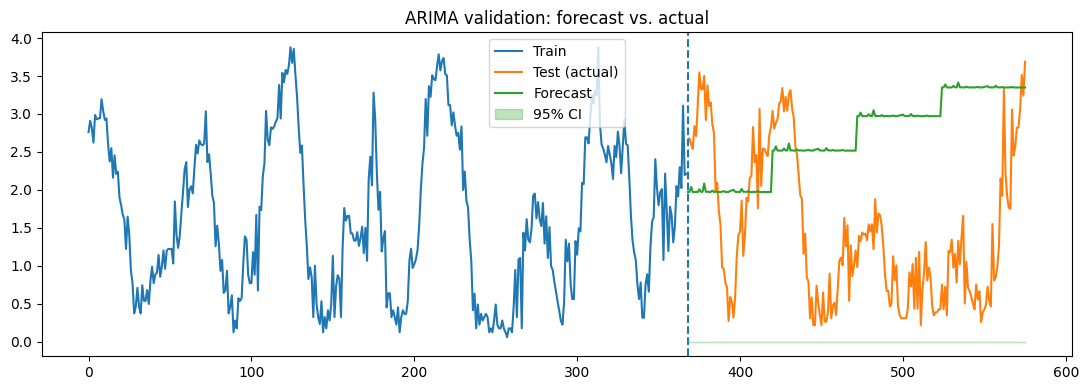

In [14]:
# -------------------------------------------------------------
# 6. Plot: train, validation, forecast, and 95 % CI
# -------------------------------------------------------------
plt.figure(figsize=(11, 4))
plt.plot(np.arange(n_train), train, label="Train")
plt.plot(np.arange(n_train, n_train+n_test), test, label="Test (actual)")
plt.plot(np.arange(n_train, n_train+n_test), pred_mean, label="Forecast", color='C2')
plt.fill_between(np.arange(n_train, n_train+n_test),
                 ci[:, 0],
                 ci[:, 1],
                 alpha=0.3, label="95% CI", color='C2')
plt.axvline(n_train, linestyle="--")  # marks forecast origin
plt.title("ARIMA validation: forecast vs. actual")
plt.legend()
plt.tight_layout()

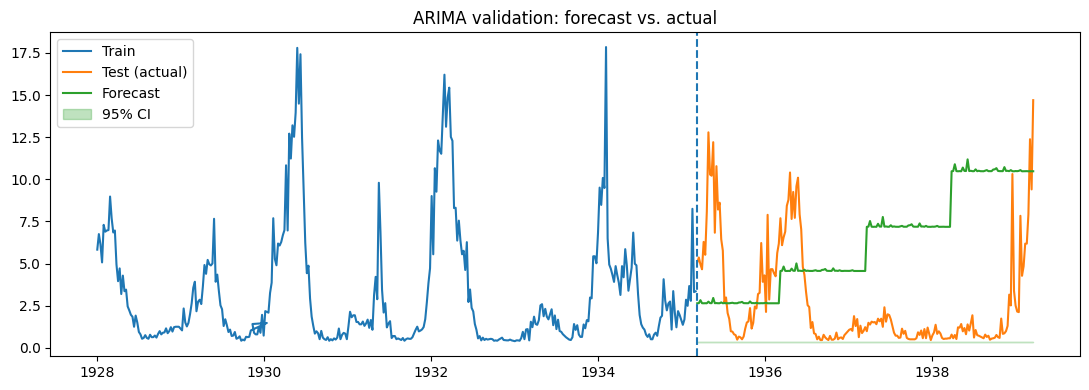

In [15]:
# -------------------------------------------------------------
# 6. Plot: train, validation, forecast, and 95 % CI
# -------------------------------------------------------------
plt.figure(figsize=(11, 4))
plt.plot(series.index[:n_train], np.exp(train-1), label="Train")
plt.plot(series.index[n_train:(n_train+n_test)], np.exp(test-1), label="Test (actual)")
plt.plot(series.index[n_train:(n_train+n_test)], np.exp(pred_mean-1), label="Forecast", color='C2')
plt.fill_between(series.index[n_train:(n_train+n_test)],
                 np.exp(ci[:, 0]-1),
                 np.exp(ci[:, 1]-1),
                 alpha=0.3, label="95% CI", color='C2')
plt.axvline(series.index[n_train], linestyle="--")  # marks forecast origin
plt.title("ARIMA validation: forecast vs. actual")
plt.legend()
plt.tight_layout()